<a href="https://colab.research.google.com/github/hsfcoulibaly/talking_agent/blob/main/01_vlm_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q transformers accelerate bitsandbytes Pillow requests
!pip install --upgrade accelerate bitsandbytes transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 112.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [1]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

model_id = "llava-hf/llava-1.5-7b-hf"

print("Loading processor...")
processor = AutoProcessor.from_pretrained(model_id)

# 1. Create the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4", # Added for more memory efficiency
    bnb_4bit_use_double_quant=True, # Added for further memory reduction
    llm_int8_enable_fp32_cpu_offload=True # Added to allow CPU offloading for 32-bit modules
)

print("Loading model (this takes a minute)...")
# 2. Pass the config into the model loader
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config
)
print("Model loaded successfully!")

Loading processor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading model (this takes a minute)...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Model loaded successfully!


In [2]:
print('Re-installing bitsandbytes to ensure it is correctly linked...')
!pip install -U bitsandbytes
print('bitsandbytes re-installation complete. Please proceed to the next cells.')

Re-installing bitsandbytes to ensure it is correctly linked...
bitsandbytes re-installation complete. Please proceed to the next cells.


Input Image:


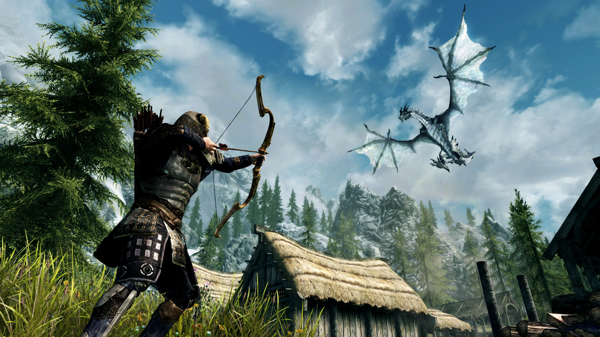


--- EXTRACTION RESULT ---
* The environment consists of a forest with a hut and a mountain in the background.
* The main character is a man holding a bow and arrow, preparing to shoot a dragon.
* The dragon is flying in the air, close to the man.
* The man is wearing a suit of armor, which suggests that he is a warrior or a knight.
* The scene is set in a fantasy world, as indicated by the presence of


In [3]:
from PIL import Image
import requests
from IPython.display import display

# For testing, we use a sample image URL.
image_url = "https://cdn.mos.cms.futurecdn.net/zybUnVij2nDHe2daBFgLxH.jpg" # Replace with your game image
image = Image.open(requests.get(image_url, stream=True).raw)

print("Input Image:")
display(image.resize((600, 337))) # Resize just for displaying in the notebook

# Define the prompt asking for a structured extraction
prompt = "USER: <image>\nDescribe the environment, characters, and action in this game screenshot. Format the response as a simple list of key events and objects. \nASSISTANT:"

# Process the inputs and send them to the GPU
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda")

# Generate the output
output = model.generate(**inputs, max_new_tokens=100)
response = processor.decode(output[0], skip_special_tokens=True)

print("\n--- EXTRACTION RESULT ---")
# Split the response to only show what the Assistant generated
print(response.split("ASSISTANT:")[1].strip())

In [ ]:
from PIL import Image
import requests
from IPython.display import display

# For testing, we use a sample image URL.
image_url = "https://cdn.mos.cms.futurecdn.net/zybUnVij2nDHe2daBFgLxH.jpg" # Replace with your game image
image = Image.open(requests.get(image_url, stream=True).raw)

print("Input Image:")
display(image.resize((600, 337))) # Resize just for displaying in the notebook

# Define the prompt asking for a structured extraction
prompt = "USER: <image>\nDescribe the environment, characters, and action in this game screenshot. Format the response as a simple list of key events and objects. \nASSISTANT:"

# Process the inputs and send them to the GPU
inputs = processor(prompt, image, return_tensors="pt").to("cuda")

# Generate the output
output = model.generate(**inputs, max_new_tokens=100)
response = processor.decode(output[0], skip_special_tokens=True)

print("\n--- EXTRACTION RESULT ---")
# Split the response to only show what the Assistant generated
print(response.split("ASSISTANT:")[1].strip())